In [1]:
import recon
import plotting as plot
import numpy as np
import seaborn as sns
import pandas as pd
import utilities
import workflows as wf
import warnings
warnings.filterwarnings('ignore')


model = recon.Recon()
util = utilities.Utilities()

### Metabolomics data

In [2]:
mets_hek = pd.read_csv('../data/metabolomics_HEK293.csv',
                       sep='\t', index_col=0)
met_slc25a51ko = pd.read_csv('../data/metabolomics_slc25a51ko_vs_parental.csv', 
                             sep='\t', index_col=0)
met_uc = pd.read_csv('../data/metabolomics_uc_vs_healthy.csv', sep=',')

### Predicted change

In [3]:
res_slc25a51ko = pd.read_csv('../data/pr_slc25a51ko_wt.csv', sep='\t', index_col=0)
res_slc25a51ko_pvalue = pd.read_csv('../data/pr_slc25a51ko_wt_pvalue.csv', sep='\t', index_col=0)
res_uc = pd.read_csv('../data/pr_prot_uc_vs_healthy.csv', sep='\t', index_col=0)

### RNA-Seq data

In [4]:
rna_slc25a51ko = pd.read_csv('../data/rnaseq_slc25a51ko_vs_parental.csv', sep='\t', index_col=0)
rna_slc25a51ko = util.map_gene(df=rna_slc25a51ko, g_mapping=model.genes, mapping_column='ensembl_gene')
rna_slc25a51ko_pvalue = pd.read_csv('../data/rnaseq_slc25a51ko_vs_parental_pvalue.csv', index_col=0)
rna_slc25a51ko_pvalue.index = rna_slc25a51ko_pvalue.index.astype('str')

# Parity plots with standard deviation

### Figure S1 (SLC25A51ko vs Parental)

In [6]:
def prep_data(mets, res):
    df = pd.concat((mets.mean(axis=1), res.mean(axis=1),
                    mets.std(axis=1), res.std(axis=1)), axis=1).dropna()
    df.columns = ['Measured', 'Predicted', 'Measured std_dev',
                  'Predicted std_dev']
    return df
def rename_index(df):
    df = df.rename(index={'Adenosine monophosphate': 'AMP',
                          'Adenosine triphosphate': 'ATP',
                          'Cyclic AMP': 'cAMP',
                          '2,3-Diphosphoglyceric acid': '2,3-DPG',
                          '6-Phosphogluconic acid': '6PG',
                          'D-Sedoheptulose 7-phosphate': 'S7P',
                          'Fructose 1,6-bisphosphate': 'F16BP',
                          'Fructose 6-phosphate': 'F6P',
                          'Glucose 1-phosphate': 'G1P',
                          'Glucose 6-phosphate': 'G6P',
                          'Phosphoenolpyruvic acid': 'PEP',
                          'S-Adenosylmethionine': 'SAM',
                          'N-Acetyl-L-aspartic acid': 'NAA',
                          'Hydroxykynurenine': '3OHKYN'})
    return df

In [13]:
# with consistent metabolite names
# res_HEK = util.get_consistent_mets(res_slc25a51ko)
res_HEK = res_slc25a51ko.copy()
res_HEK = util.reshape(res_HEK, include=None)

_res = res_HEK[res_HEK.compartment.isin(['mitochondrial', 'nuclear', 'cytoplasm'])].groupby(
    'metabolites').mean(numeric_only=True)
_res_m = res_HEK[res_HEK.compartment == 'mitochondrial'].groupby(
    'metabolites').mean(numeric_only=True)
_res_n = res_HEK[res_HEK.compartment == 'nuclear'].groupby(
    'metabolites').mean(numeric_only=True)
_res_c = res_HEK[res_HEK.compartment == 'cytoplasm'].groupby(
    'metabolites').mean(numeric_only=True)
df_mean = prep_data(mets=met_slc25a51ko, res=_res)
df_m = prep_data(mets=met_slc25a51ko, res=_res_m)
df_n = prep_data(mets=met_slc25a51ko, res=_res_n)
df_c = prep_data(mets=met_slc25a51ko, res=_res_c)

In [15]:
TS1 = pd.concat((df_mean, mets_hek['pvalue']), axis=1).dropna()
TS1 = TS1.rename(index={'ADP': 'Adenosine diphosphate'})
TS1 = TS1.reset_index().rename(columns={'index': 'Metabolite name'})
TS1.to_csv('../Supplementary_Table_S1.csv',
           index=False, sep='\t', float_format='%.3f')

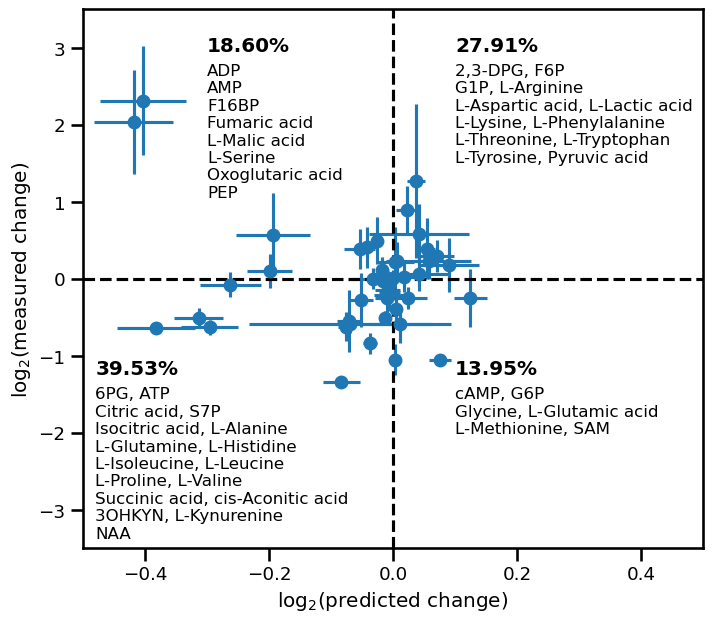

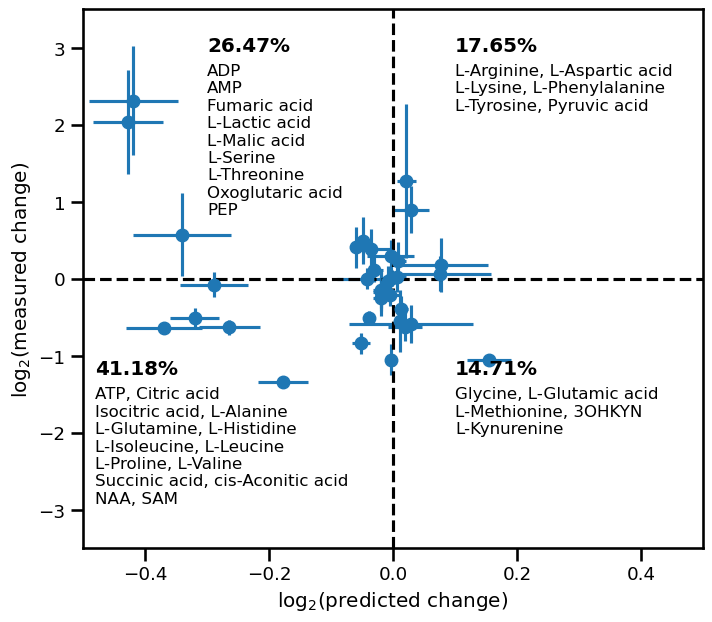

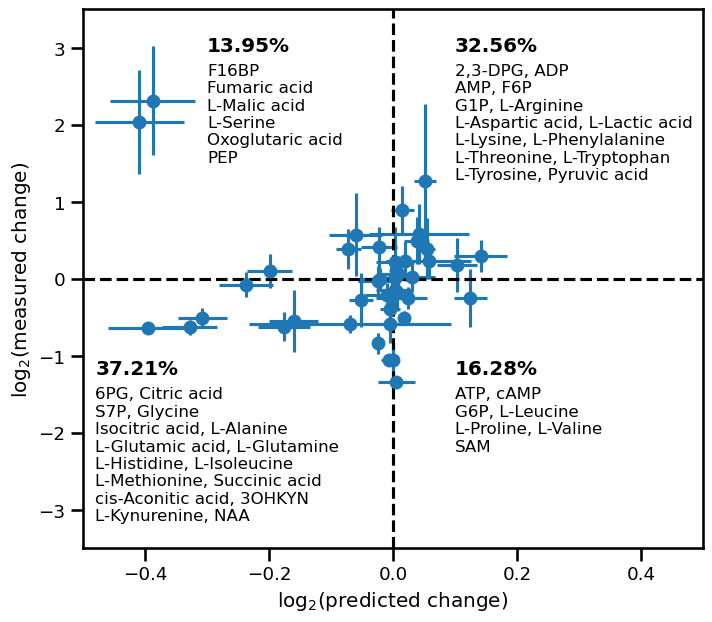

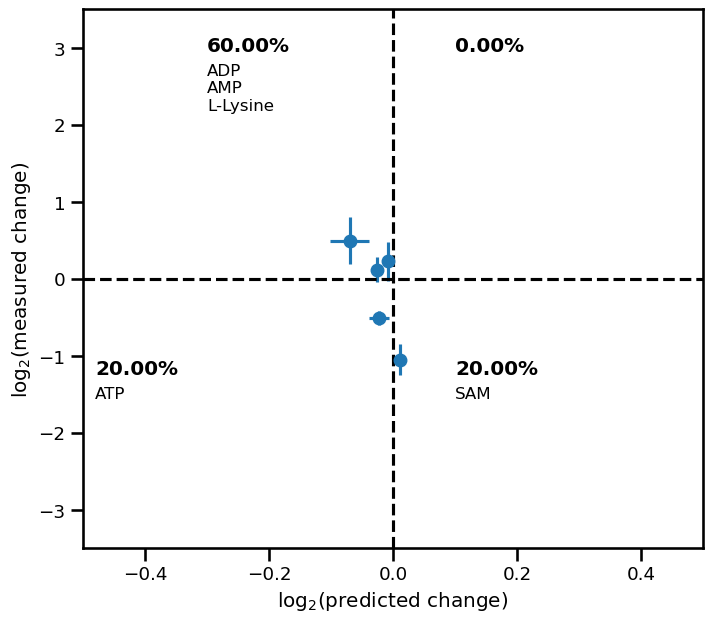

In [16]:
# Figure S1b, c, d
sns.set_context('talk', font_scale=0.8)

suffix = ['a', 'b', 'c', 'd']
for i, df in enumerate([df_mean, df_m, df_c, df_n]):
    _df = rename_index(df[~df.index.isin(['D-Glucose', 'Nicotinic acid'])])
    plot.parity_with_errorbars(df=_df, xcolumn='Predicted', ycolumn='Measured',
                               xerr_column='Predicted std_dev', yerr_column='Measured std_dev',
                               figsize=(8, 7), show_metabolite_names=True, show_percentage=True,
                               fsize=12, xlim=(-0.5, 0.5), ylim=(-3.5, 3.5),
                               l_p=[(0.2, 0.95), (0.6, 0.95), (0.02, 0.35), (0.6, 0.35)],
                               l_n=[(0.2, 0.90), (0.6, 0.90), (0.02, 0.30), (0.6, 0.30)],
                               save=True, filename=f'../../biomarker_predictions/manuscript/submission/images/Figure_S1{suffix[i]}.svg', 
                               n_n=[1, 2, 2, 2])

## Figure S2

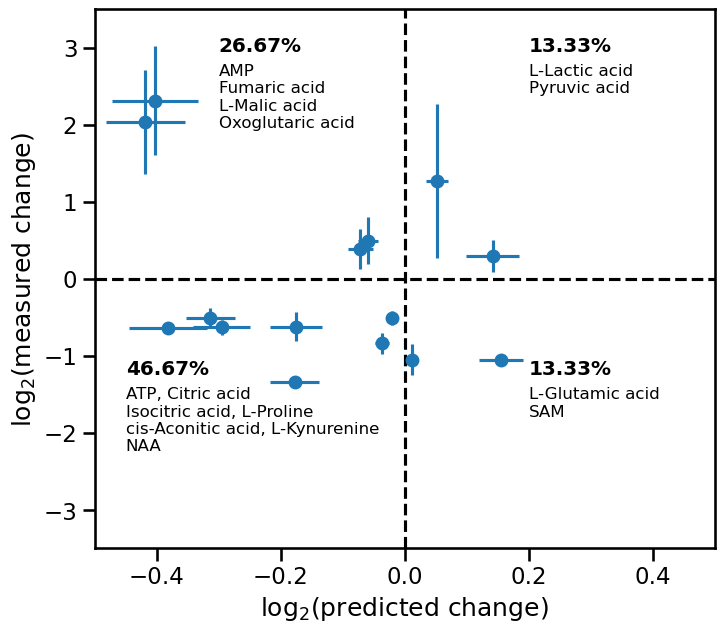

In [21]:
# Figure S2a
sns.set_context('talk', font_scale=1.0)

_df = df_mean[df_mean.index.isin(mets_hek[mets_hek.pvalue < 0.05].index)]
_df = rename_index(_df[~_df.index.isin(['D-Glucose', 'Nicotinic acid'])])
plot.parity_with_errorbars(df=_df, xcolumn='Predicted', ycolumn='Measured',
                           xerr_column='Predicted std_dev', yerr_column='Measured std_dev',
                           figsize=(8, 7), show_metabolite_names=True, show_percentage=True,
                           fsize=12, xlim=(-0.5, 0.5), ylim=(-3.5, 3.5),
                           l_p=[(0.2, 0.95), (0.7, 0.95), (0.05, 0.35), (0.7, 0.35)],
                           l_n=[(0.2, 0.90), (0.7, 0.90), (0.05, 0.30), (0.7, 0.30)],
                           save=True, filename='../../biomarker_predictions/manuscript/submission/images/Figure_S2a.svg',
                           n_n=[1, 1, 2, 1])

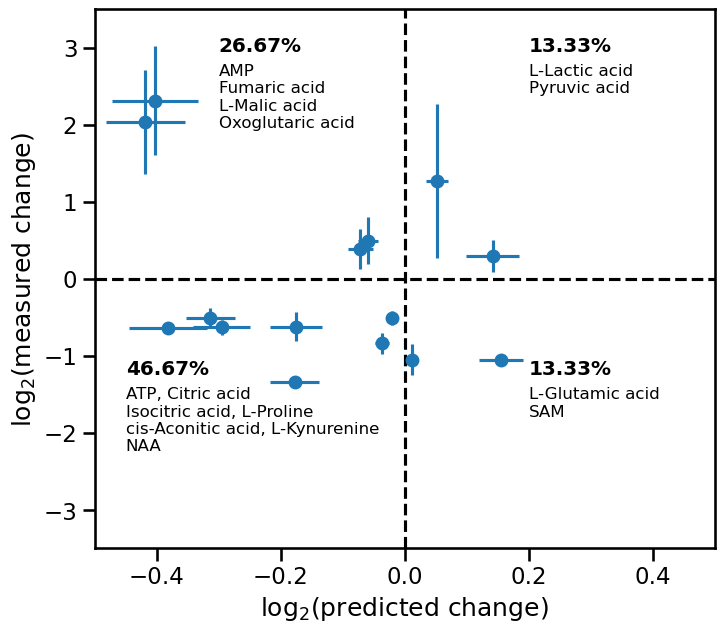

In [22]:
# Figure S2b
sns.set_context('talk', font_scale=1.0)
res_HEK = util.get_consistent_mets(res_slc25a51ko)
res_HEK = util.reshape(res_HEK, include=None)

_res = res_HEK[res_HEK.compartment.isin(['mitochondrial', 'nuclear', 'cytoplasm'])].groupby(
    'metabolites').mean(numeric_only=True)
df_mean = prep_data(mets=met_slc25a51ko, res=_res)

_df = df_mean[df_mean.index.isin(mets_hek[mets_hek.pvalue < 0.05].index)]
_df = rename_index(_df[~_df.index.isin(['D-Glucose', 'Nicotinic acid'])])
plot.parity_with_errorbars(df=_df, xcolumn='Predicted', ycolumn='Measured',
                           xerr_column='Predicted std_dev', yerr_column='Measured std_dev',
                           figsize=(8, 7), show_metabolite_names=True, show_percentage=True,
                           fsize=12, xlim=(-0.5, 0.5), ylim=(-3.5, 3.5),
                           l_p=[(0.2, 0.95), (0.7, 0.95), (0.05, 0.35), (0.7, 0.35)],
                           l_n=[(0.2, 0.90), (0.7, 0.90), (0.05, 0.30), (0.7, 0.30)],
                           save=True, filename='../../biomarker_predictions/manuscript/submission/images/Figure_S2b.svg',
                           n_n=[1, 1, 2, 1])

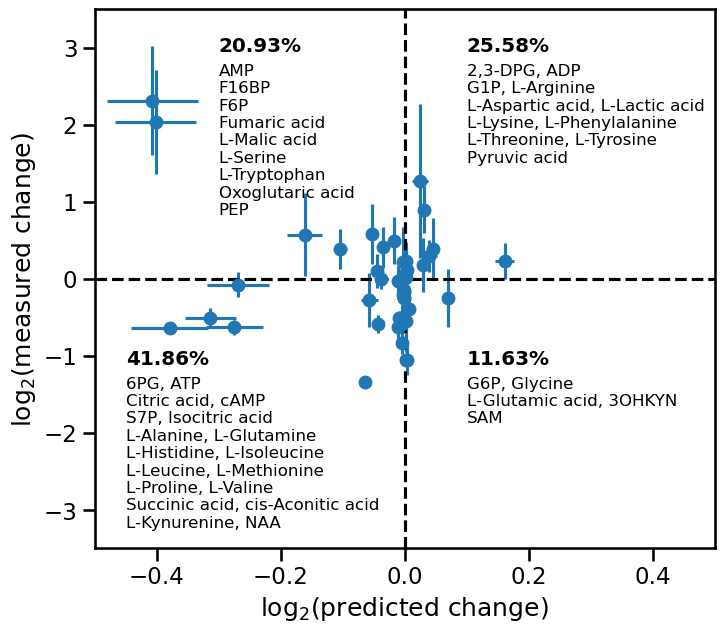

In [24]:
# Figure S2c
sns.set_context('talk', font_scale=1.0)
res_HEK = util.reshape(res_slc25a51ko_pvalue, include=None)
_res = res_HEK[res_HEK.compartment.isin(['mitochondrial', 'nuclear', 'cytoplasm'])].groupby(
    'metabolites').mean(numeric_only=True)
df_mean = prep_data(mets=met_slc25a51ko, res=_res)
_df = df_mean.copy()
_df = rename_index(_df[~_df.index.isin(['D-Glucose', 'Nicotinic acid'])])
plot.parity_with_errorbars(df=_df, xcolumn='Predicted', ycolumn='Measured',
                           xerr_column='Predicted std_dev', yerr_column='Measured std_dev',
                           figsize=(8, 7), xlim=(-0.5, 0.5), ylim=(-3.5, 3.5),
                           show_metabolite_names=True, show_percentage=True,
                           l_p=[(0.2, 0.95), (0.6, 0.95), (0.05, 0.37), (0.6, 0.37)],
                           l_n=[(0.2, 0.90), (0.6, 0.90), (0.05, 0.32), (0.6, 0.32)],
                           save=False, filename='../../biomarker_predictions/manuscript/submission/images/Figure_S2c.svg',
                           n_n=[1, 2, 2, 2], fsize=12)

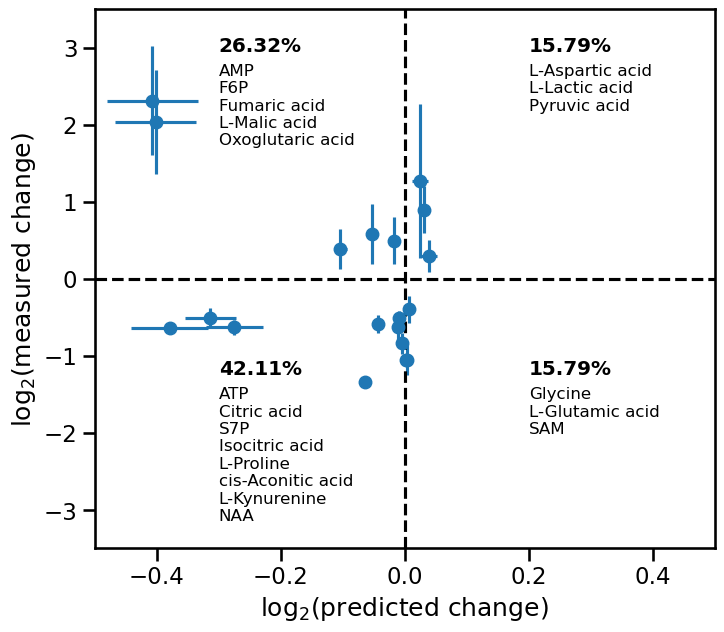

In [25]:
# Figure S2d
sns.set_context('talk', font_scale=1.0)
_df = df_mean[df_mean.index.isin(mets_hek[mets_hek.pvalue < 0.05].index)]
_df = rename_index(_df[~_df.index.isin(['D-Glucose', 'Nicotinic acid'])])
plot.parity_with_errorbars(df=_df, xcolumn='Predicted', ycolumn='Measured',
                           xerr_column='Predicted std_dev', yerr_column='Measured std_dev',
                           figsize=(8, 7), show_metabolite_names=True, show_percentage=True,
                           fsize=12, xlim=(-0.5, 0.5), ylim=(-3.5, 3.5),
                           l_p=[(0.2, 0.95), (0.7, 0.95), (0.2, 0.35), (0.7, 0.35)],
                           l_n=[(0.2, 0.90), (0.7, 0.90), (0.2, 0.30), (0.7, 0.30)],
                           save=True, filename='../../biomarker_predictions/manuscript/submission/images/Figure_S2d.svg',
                           n_n=[1, 1, 1, 1])

In [26]:
# Figure S2e
# with consistent metabolite names
res_HEK = util.get_consistent_mets(res_slc25a51ko_pvalue)
res_HEK = util.reshape(res_HEK, include=None)

_res = res_HEK[res_HEK.compartment.isin(['mitochondrial', 'nuclear', 'cytoplasm'])].groupby(
    'metabolites').mean(numeric_only=True)
df_mean = prep_data(mets=met_slc25a51ko, res=_res)

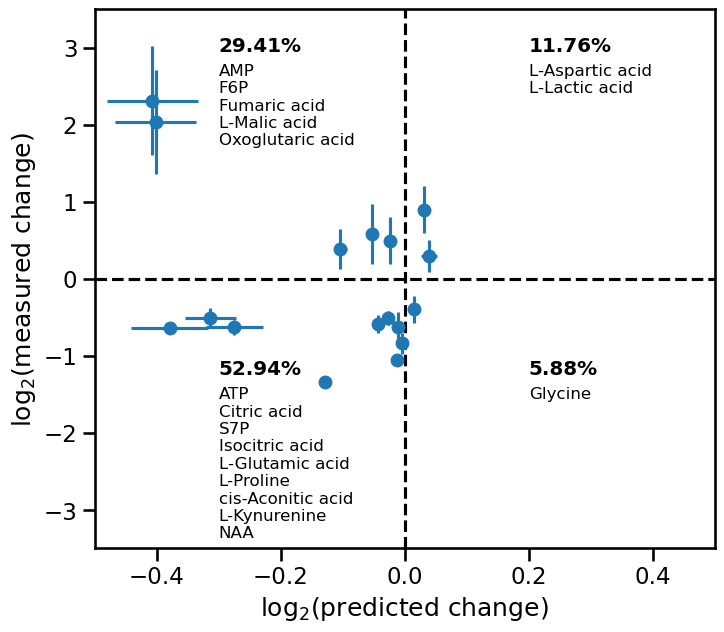

In [27]:
# _df = df_mean.copy()
_df = df_mean[df_mean.index.isin(mets_hek[mets_hek.pvalue < 0.05].index)]
_df = rename_index(_df[~_df.index.isin(['D-Glucose', 'Nicotinic acid'])])
plot.parity_with_errorbars(df=_df, xcolumn='Predicted', ycolumn='Measured',
                           xerr_column='Predicted std_dev', yerr_column='Measured std_dev',
                           figsize=(8, 7), show_metabolite_names=True, show_percentage=True,
                           fsize=12, xlim=(-0.5, 0.5), ylim=(-3.5, 3.5),
                           l_p=[(0.2, 0.95), (0.7, 0.95),
                                (0.2, 0.35), (0.7, 0.35)],
                           l_n=[(0.2, 0.90), (0.7, 0.90),
                                (0.2, 0.30), (0.7, 0.30)],
                           save=True, filename='../../biomarker_predictions/manuscript/submission/images/Figure_S2e.svg',
                           n_n=[1, 1, 1, 1])

### Figure S3

In [29]:
df = util.reshape(res_uc).groupby('metabolites').mean(numeric_only=True).reset_index()
df = met_uc.merge(df, right_on='metabolites', left_on='vmh', how='inner')
df = df.set_index('metabolites').drop('vmh', axis=1)
df.columns = ['p', 'padj', 'Measured', 'Predicted']
df['hue'] = 'C1'
df.loc[(df.p > 0.05), 'hue'] = 'grey'
df.loc[(df.Predicted < 1.01) & (df.Predicted > 0.99), 'hue'] = 'grey'

In [30]:
TS2 = df.reset_index().rename(columns={'metabolites': 'Metabolite name', 'p': 'p-value'})
TS2.drop(['padj', 'hue'], axis=1).to_csv('../Supplementary_Table_S2.csv',
                                  index=False, sep='\t', float_format='%.3f')

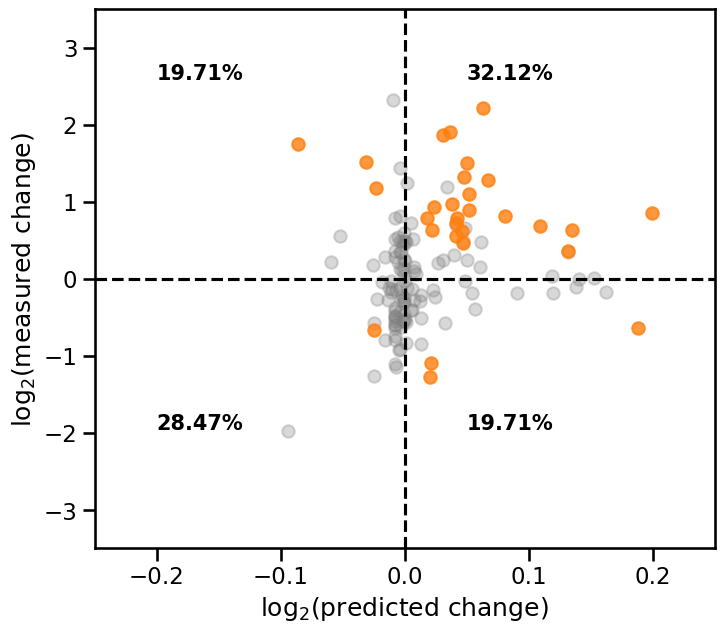

In [31]:
sns.set_context('talk', font_scale=1.0)
import matplotlib.pyplot as plt
xcolumn='Predicted'
ycolumn='Measured'
xlim=(-0.25, 0.25) 
ylim=(-3.5, 3.5)
xlabel='log$_2$(predicted change)' 
ylabel='log$_2$(measured change)'
l_p=[(0.1, 0.9), (0.6, 0.9), (0.1, 0.25), (0.6, 0.25)]
            
fig, ax = plt.subplots(figsize=(8,7))
ax.scatter(x=np.log2(df[df.hue=='grey'][xcolumn]), y=np.log2(df[df.hue=='grey'][ycolumn]), 
        c='grey', alpha=0.3)
ax.scatter(x=np.log2(df[df.hue!='grey'][xcolumn]), y=np.log2(df[df.hue!='grey'][ycolumn]), 
        c='C1', alpha=0.8)
ax.axhline(y=0.0, c='k', ls='--')
ax.axvline(x=0.0, c='k', ls='--')
plt.xlim(xlim)
plt.ylim(ylim)
ax.set_xlabel(xlabel)
ax.set_ylabel(ylabel)
plot.add_percentage(df=df, ax=ax, colname2='Predicted', colname='Measured',
                    show_sc_percentages=False, fsize=15, 
                    l=l_p[0], l2=l_p[1], l3=l_p[2], l4=l_p[3]
                    )
fig.savefig('../../biomarker_predictions/manuscript/submission/images/Figure_S3_new.png', dpi=300, bbox_inches='tight')